In [1]:

import numpy
import pandas
from matplotlib import pyplot as plt


In [2]:

emb = pandas.read_parquet('embedding.parquet').set_index('time')
emb.shape


(7322, 1024)

(0.0, 128.0)

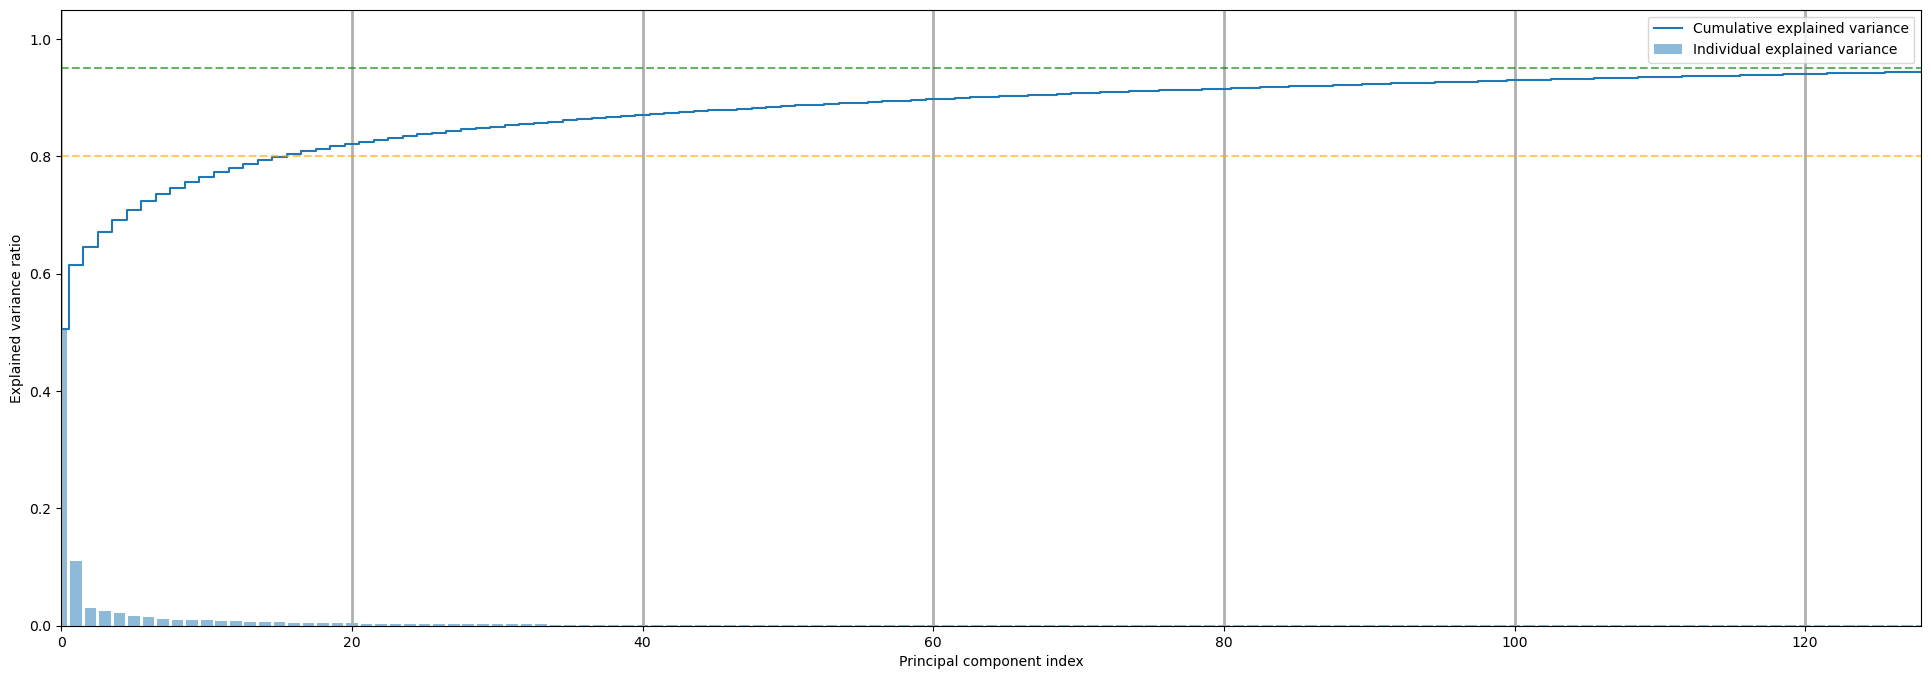

In [165]:
def compute_pca(X):

    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    sc.fit(X)
    X_std = sc.transform(X)
    pca = PCA()
    X_pca = pca.fit_transform(X_std)
    X_pca.shape

    return pca

def plot_pca_variance(ax, pca):

    exp_var_pca = pca.explained_variance_ratio_

    cum_sum_eigenvalues = numpy.cumsum(exp_var_pca)
    
    ax.bar(range(0,len(exp_var_pca)), exp_var_pca,
           alpha=0.5,
           align='center',
           label='Individual explained variance')
    ax.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues,
            where='mid',
            label='Cumulative explained variance')
    ax.set_ylabel('Explained variance ratio')
    ax.set_xlabel('Principal component index')
    ax.legend(loc='best')
    ax.axhline(0.80, ls='--', alpha=0.6, color='orange')
    ax.axhline(0.95, ls='--', alpha=0.6, color='green')
    ax.grid(True, axis='x', lw=2.0) 

fig, ax = plt.subplots(1, figsize=(24,8))
pca = compute_pca(emb)
plot_pca_variance(ax, pca)
ax.set_xlim(0, 128)

In [14]:

def read_labels(path):
    labels = pandas.read_csv(path, sep='\t', header=None,
                            names=['start', 'end', 'annotation'],
                            dtype=dict(start=float,end=float,annotation=str))
    return labels

labels = read_labels('Conference_speakers.txt')
labels.head()


,start,end,annotation
0,4.005756,167.682063,Trym
1,169.743900,312.949668,Morten
2,313.678120,603.579771,Oystein
3,604.842930,613.474521,Alexa
4,615.579787,732.000998,Oystein


In [15]:
labels.annotation.value_counts()

Morten     31
Oystein    13
Jon         9
Audun       6
Iver        3
Trym        1
Alexa       1
Name: annotation, dtype: int64

In [16]:
labels = labels[~labels.annotation.isin(['Trym', 'Alexa', 'Iver'])] # remove tiny classes
labels.annotation.value_counts()

Morten     31
Oystein    13
Jon         9
Audun       6
Name: annotation, dtype: int64

In [69]:
def label_timeseries(timeseries, labels, label_column='label'):
    """
    NOTE: assumes a single label per time period
    """
    
    df = timeseries.copy()
    for start, end, label in zip(labels.start, labels.end, labels.annotation):
        df.loc[start:end, label_column] = label

    return df

emb_labeled = label_timeseries(emb, labels=labels)
emb_labeled.label.value_counts(dropna=False)

Morten     1816
Jon        1757
Oystein    1647
Audun      1317
NaN         785
Name: label, dtype: int64

In [70]:
def undersample(df, class_column='label'):
    
    classes = df[class_column].value_counts().to_dict()
    least_class_amount = min(classes.values())
    classes_list = []
    for key in classes:
        classes_list.append(df[df[class_column] == key]) 
    classes_sample = []
    
    for i in range(0,len(classes_list)-1):
        classes_sample.append(classes_list[i].sample(least_class_amount))

    df_maybe = pandas.concat(classes_sample)
    final_df = pandas.concat([df_maybe, classes_list[-1]], axis=0)
    #final_df = final_df.reset_index(drop=True)
    return final_df

#undersample(train_data).label.value_counts()

In [173]:

def split_input_labels(data):
    feature_columns = data.columns[(data.columns.str.startswith('e'))]
    X = data[feature_columns]
    Y = data[['label']]
    return X, Y

# TODO: share this function
def split_data(data):
    # drop unlabeled data
    data = data.dropna(subset=['label'])

    # time-series split off test set
    test_start_time = 1900.0
    test_start_idx = numpy.argmin(test_start_time - data.index)
    train_data = data.loc[0:test_split_time]   
    test_data = data.loc[test_split_time:]

    # balance training data wrt to samples-per-class
    train_data = undersample(train_data)

    # random split off validation set
    train_data, val_data = sklearn.model_selection.train_test_split(train_data, test_size=0.3)

    return train_data, val_data, test_data

train_data, val_data, test_data = split_data(emb_labeled)

X_train, y_train = split_input_labels(train_data)
X_test, y_test = split_input_labels(test_data)

print('train')
print(y_train.value_counts())
print('test')
print(y_test.value_counts())

train
label  
Oystein    423
Morten     414
Jon        411
Audun      406
dtype: int64
test
label  
Morten     1225
Oystein     739
Jon         692
Audun       322
dtype: int64


In [177]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
import sklearn.metrics

estimator = make_pipeline(
    StandardScaler(),
    PCA(32),
    KNeighborsClassifier(32),
    #DummyClassifier(),
)

# TODO: balance out the different speakers in training set
# TODO: see what happens with performance as we reduce training set size. Run multiple experiments per size, random samples

scorer = sklearn.metrics.make_scorer(sklearn.metrics.f1_score, average = 'macro')
scores = cross_val_score(estimator=estimator, X=X_train, y=numpy.squeeze(y_train), scoring=scorer)
estimator.fit(X_train, y_train) # re-fit entire dataset

scores

/home/jon/.local/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


array([0.67214487, 0.75814616, 0.69022166, 0.72672394, 0.73364028])

In [178]:
scorer(estimator, X_test, y_test)

0.5928072193685795

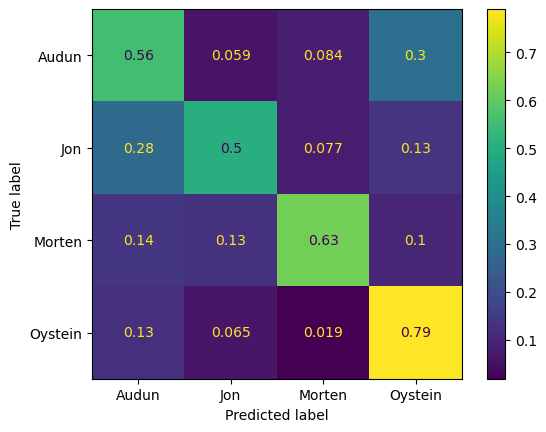

In [179]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(estimator, X_test, y_test, normalize='true')

In [180]:
pred = estimator.predict(X_test)
pred = pandas.Series(pred, index=test_data.index, name='label').to_frame()
pred

,label
time,
1900.32,Jon
1900.80,Jon
1901.28,Oystein
1901.76,Oystein
1902.24,Oystein
...,...
3508.80,Oystein
3509.28,Morten
3509.76,Audun


In [181]:
def predict_proba(estimator, data):
    """
    predict_proba with proper pandas.DataFrame support
    """

    X = data[feature_columns] # XXX: global
    pp = estimator.predict_proba(X)
    df = pandas.DataFrame(pp, index=data.index, columns=estimator.classes_)

    return df

pp = predict_proba(estimator, test_data)
pp

,Audun,Jon,Morten,Oystein
time,,,,
1900.32,0.21875,0.40625,0.34375,0.03125
1900.80,0.18750,0.37500,0.15625,0.28125
1901.28,0.12500,0.18750,0.21875,0.46875
1901.76,0.15625,0.28125,0.15625,0.40625
1902.24,0.15625,0.28125,0.15625,0.40625
...,...,...,...,...
3508.80,0.28125,0.18750,0.18750,0.34375
3509.28,0.37500,0.06250,0.40625,0.15625
3509.76,0.46875,0.25000,0.12500,0.15625


In [182]:
def temporal_smoothing(df, lookback='3s', agg='median'):
    lookback = pandas.Timedelta(lookback)
    
    df = df.sort_index()

    df.index = pandas.to_timedelta(df.index, unit='s')

    out = df.copy()
    for end in df.index:
        start = max(end - lookback, df.index.min())
        #print('s', start, end)
        window = out.loc[start:end]
        out.loc[end] = window.agg(agg, axis=0)

    out.index = out.index.total_seconds()
    
    return out

ll = temporal_smoothing(pp, lookback='4s', agg='mean')
ll.head(20)
    

,Audun,Jon,Morten,Oystein
time,,,,
1900.32,0.218750,0.406250,0.343750,0.031250
1900.80,0.203125,0.390625,0.250000,0.156250
1901.28,0.182292,0.328125,0.270833,0.218750
1901.76,0.190104,0.351562,0.255208,0.203125
1902.24,0.190104,0.351562,0.255208,0.203125
1904.16,0.210938,0.382812,0.265625,0.140625
1904.64,0.199219,0.321615,0.325521,0.153646
1905.12,0.172526,0.351780,0.306858,0.168837
1905.60,0.212565,0.334889,0.276403,0.176143


In [183]:
# FIXME: make this into a function
class_map_idx = dict(zip(range(0, 4), estimator.classes_))
class_map_idx

llp = ll.values.argmax(axis=1)

smooth = pandas.Series(llp, index=ll.index).replace(class_map_idx)
smooth.value_counts()

Morten     1017
Oystein     902
Jon         558
Audun       501
dtype: int64

In [184]:
sklearn.metrics.f1_score(y_true=y_test, y_pred=pred, average = 'macro')

0.5928072193685795

In [185]:
sklearn.metrics.f1_score(y_true=y_test, y_pred=smooth, average = 'macro')


0.7125348049356932

In [31]:
# TODO: also add/try HMM-GMM smoothing



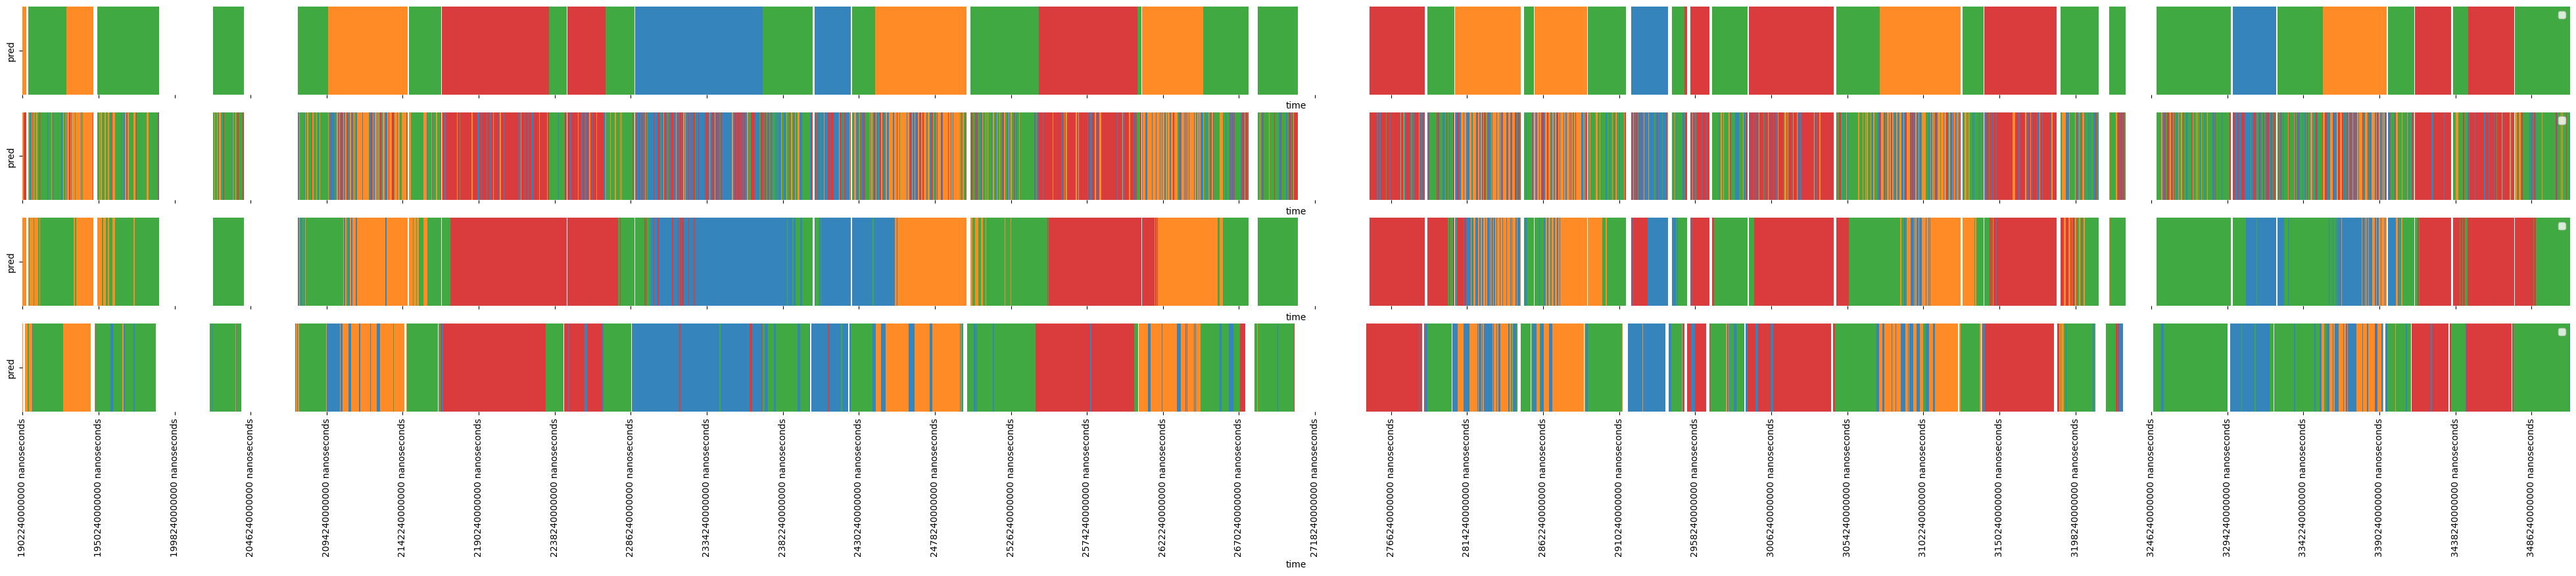

In [229]:
def plot_mapping(ax, labeled, palette = 'tab10'):
    
    colors = seaborn.color_palette(palette)
    colors = colors[0:labeled.nunique()]

    # TODO: support categorical names for labels, not just indices
    enc = LabelEncoder()
    labeled = pandas.Series(enc.fit_transform(labeled), index=labeled.index)
    
    # handle holes in the input data
    hop_duration = 0.480
    full_times = numpy.arange(labeled.index.min(), labeled.index.max(), hop_duration)
    full = pandas.DataFrame({ 'time': pandas.to_timedelta(full_times, unit='s'), 'pred': None }).set_index('time')
    df = labeled.copy()
    df.index = pandas.to_timedelta(df.index, unit='s')
    full['pred'] = df

    
    df = full.T
    seaborn.heatmap(df, ax=ax, cmap=colors, xticklabels=100, cbar=False, alpha=0.9)

    # FIXME: add a legend with labels
    labels = enc.inverse_transform(range(len(colors)))
    ax.legend(labels=labels)


fig, (ref_ax, pred_ax, smooth_ax, deep_ax)  = plt.subplots(4, figsize=(50, 8), sharex=True)

plot_mapping(ref_ax, test_data['label'])
plot_mapping(pred_ax, pred['label'])
plot_mapping(smooth_ax, smooth)
plot_mapping(deep_ax, deep)


In [226]:

def one_hot_encode(labels, classes=['Audun', 'Jon', 'Morten', 'Oystein']):
    hot = sklearn.preprocessing.label_binarize(labels, classes=classes)
    ll = pandas.DataFrame(hot, index=labels.index, columns=classes)
    return ll
   
def make_datasets(train, val, test,
                  sequence_length=5,
                  sequence_stride=1,
                  batch_size=128):

    import tensorflow.data
    from tensorflow.keras.utils import timeseries_dataset_from_array
                      
    def timeseries_split(X):
        dataset = timeseries_dataset_from_array(X, None,
            sequence_length=sequence_length,
            sequence_stride=sequence_stride,
            batch_size=batch_size,
            #shuffle=shuffle,
        )
        return dataset
        
    def to_windows(data : pandas.DataFrame):
        X, Y = split_input_labels(data)
        Y = one_hot_encode(Y)
        
        # XXX: timeseries_dataset_from_array does not support labels that are a sequence
        # so instead do it in two operations and merge the data together
        inputs = timeseries_split(X.values)
        labels = timeseries_split(Y.values)
        dataset = tensorflow.data.Dataset.zip((inputs, labels))

        return dataset

    # PERF: this augmentation makes things almost 5x slower...
    def augment(x, y):
        noise = tensorflow.random.uniform(shape=tensorflow.shape(x), minval=0.0, maxval=0.01)
        x = x + noise
        return x, y
        
    train = to_windows(train).map(augment)
    val = to_windows(val)
    test = to_windows(test)

    return train, val, test

tensorflow.data.experimental.enable_debug_mode()

train_dataset, val_dataset, test_dataset = make_datasets(train_data, val_data, test_data)
for x, y in train_dataset:
    print(x.shape, y.shape)
    break


2023-06-05 23:35:37.789988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1650]
	 [[{{node Placeholder/_8}}]]
2023-06-05 23:35:37.790302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [1654,4]
	 [[{{node Placeholder/_19}}]]


(128, 5, 1024) (128, 5, 4)


In [227]:

def build_rnn(timesteps, n_classes,
              embedding_size=1024, embedding_reduce=128, rnn=10):

    from tensorflow.keras import layers as l
    from tensorflow.keras import Sequential
                  
    model = Sequential([
        l.Input(shape=(timesteps, embedding_size)),
        l.TimeDistributed(l.Dense(embedding_reduce)),
        l.Bidirectional(l.GRU(rnn, return_sequences=True)),
        l.Bidirectional(l.GRU(rnn, return_sequences=True)),
        l.TimeDistributed(l.Dense(n_classes)),
        l.Activation('sigmoid'),
    ])

    # FIXME: does not work with sequences
    import tensorflow_addons.metrics
    f1_metric = tensorflow_addons.metrics.F1Score(average='macro', name='f1', num_classes=4)

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  #metrics=[f1_metric],
    )

    return model

m = build_rnn(5, n_classes=4, embedding_size=1024, embedding_reduce=8, rnn=8)
print(m.summary())

tensorflow.config.run_functions_eagerly(True)

# FIXME: add f1 score for train/val
m.fit(x=train_dataset, validation_data=val_dataset, epochs=30)


2023-06-05 23:35:39.630100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-05 23:35:39.631401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-05 23:35:39.632233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_32 (TimeDi  (None, 5, 8)             8200      
 stributed)                                                      
                                                                 
 bidirectional_32 (Bidirecti  (None, 5, 16)            864       
 onal)                                                           
                                                                 
 bidirectional_33 (Bidirecti  (None, 5, 16)            1248      
 onal)                                                           
                                                                 
 time_distributed_33 (TimeDi  (None, 5, 4)             68        
 stributed)                                                      
                                                                 
 activation_16 (Activation)  (None, 5, 4)            

2023-06-05 23:35:39.908653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-06-05 23:35:39.930318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-05 23:35:39.931053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

13/13 [==============================] - ETA: 0s - loss: 1.3580

2023-06-05 23:35:43.531037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [706]
	 [[{{node Placeholder/_8}}]]
2023-06-05 23:35:43.531321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [706]
	 [[{{node Placeholder/_8}}]]
2023-06-05 23:35:43.547900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [710,1024]

13/13 [==============================] - 5s 385ms/step - loss: 1.3580 - val_loss: 1.3140
Epoch 2/30


2023-06-05 23:35:44.907134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype int32 and shape [1650]
	 [[{{node Placeholder/_27}}]]
2023-06-05 23:35:44.907410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1650]
	 [[{{node Placeholder/_8}}]]


13/13 [==============================] - ETA: 0s - loss: 1.2727

2023-06-05 23:35:48.663613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [706]
	 [[{{node Placeholder/_8}}]]
2023-06-05 23:35:48.663944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype int32 and shape [706]
	 [[{{node Placeholder/_27}}]]
2023-06-05 23:35:48.685858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [706]
	 

13/13 [==============================] - 6s 447ms/step - loss: 1.2727 - val_loss: 1.2290
Epoch 3/30


2023-06-05 23:35:50.613822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1650]
	 [[{{node Placeholder/_8}}]]
2023-06-05 23:35:50.614188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype int32 and shape [1650]
	 [[{{node Placeholder/_27}}]]


13/13 [==============================] - ETA: 0s - loss: 1.1874

2023-06-05 23:35:56.006516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [710,1024]
	 [[{{node Placeholder/_0}}]]
2023-06-05 23:35:56.006921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype int32 and shape [706]
	 [[{{node Placeholder/_27}}]]
2023-06-05 23:35:56.030769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [7

13/13 [==============================] - 7s 574ms/step - loss: 1.1874 - val_loss: 1.1532
Epoch 4/30


2023-06-05 23:35:57.939801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1654,1024]
	 [[{{node Placeholder/_0}}]]
2023-06-05 23:35:57.940376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1650]
	 [[{{node Placeholder/_8}}]]


13/13 [==============================] - ETA: 0s - loss: 1.1102

2023-06-05 23:36:03.040890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [710,4]
	 [[{{node Placeholder/_19}}]]
2023-06-05 23:36:03.041263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [710,4]
	 [[{{node Placeholder/_19}}]]
2023-06-05 23:36:03.065009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype int32 and shape [

13/13 [==============================] - 7s 544ms/step - loss: 1.1102 - val_loss: 1.0855
Epoch 5/30


2023-06-05 23:36:04.918990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [1654,4]
	 [[{{node Placeholder/_19}}]]
2023-06-05 23:36:04.919342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [1654,4]
	 [[{{node Placeholder/_19}}]]


13/13 [==============================] - ETA: 0s - loss: 1.0401

2023-06-05 23:36:09.686207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [710,4]
	 [[{{node Placeholder/_19}}]]
2023-06-05 23:36:09.686545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [710,4]
	 [[{{node Placeholder/_19}}]]
2023-06-05 23:36:09.707666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [

13/13 [==============================] - 7s 517ms/step - loss: 1.0401 - val_loss: 1.0247
Epoch 6/30


2023-06-05 23:36:11.506606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype int32 and shape [1650]
	 [[{{node Placeholder/_27}}]]
2023-06-05 23:36:11.507021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [1654,4]
	 [[{{node Placeholder/_19}}]]


13/13 [==============================] - ETA: 0s - loss: 0.9753

2023-06-05 23:36:16.282538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [710,4]
	 [[{{node Placeholder/_19}}]]
2023-06-05 23:36:16.282939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype int32 and shape [706]
	 [[{{node Placeholder/_27}}]]
2023-06-05 23:36:16.304749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [71

13/13 [==============================] - 7s 514ms/step - loss: 0.9753 - val_loss: 0.9690
Epoch 7/30


2023-06-05 23:36:18.083369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1650]
	 [[{{node Placeholder/_8}}]]
2023-06-05 23:36:18.083726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype int32 and shape [1650]
	 [[{{node Placeholder/_27}}]]


13/13 [==============================] - ETA: 0s - loss: 0.9149

2023-06-05 23:36:22.931274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [710,4]
	 [[{{node Placeholder/_19}}]]
2023-06-05 23:36:22.931637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [710,4]
	 [[{{node Placeholder/_19}}]]
2023-06-05 23:36:22.955380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [

13/13 [==============================] - 7s 537ms/step - loss: 0.9149 - val_loss: 0.9179
Epoch 8/30


2023-06-05 23:36:24.911482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype int32 and shape [1650]
	 [[{{node Placeholder/_27}}]]
2023-06-05 23:36:24.911886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1654,1024]
	 [[{{node Placeholder/_0}}]]


13/13 [==============================] - ETA: 0s - loss: 0.8584

2023-06-05 23:36:29.955260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [710,4]
	 [[{{node Placeholder/_19}}]]
2023-06-05 23:36:29.955721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype int32 and shape [706]
	 [[{{node Placeholder/_27}}]]
2023-06-05 23:36:29.978702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [71

13/13 [==============================] - 7s 534ms/step - loss: 0.8584 - val_loss: 0.8710
Epoch 9/30


2023-06-05 23:36:31.772967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [1654,4]
	 [[{{node Placeholder/_19}}]]
2023-06-05 23:36:31.773556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [1654,4]
	 [[{{node Placeholder/_19}}]]


13/13 [==============================] - ETA: 0s - loss: 0.8060

2023-06-05 23:36:36.671538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [710,1024]
	 [[{{node Placeholder/_0}}]]
2023-06-05 23:36:36.671969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [706]
	 [[{{node Placeholder/_8}}]]
2023-06-05 23:36:36.693633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [710

13/13 [==============================] - 7s 522ms/step - loss: 0.8060 - val_loss: 0.8286
Epoch 10/30


2023-06-05 23:36:38.466985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype int32 and shape [1650]
	 [[{{node Placeholder/_27}}]]
2023-06-05 23:36:38.467339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [1654,4]
	 [[{{node Placeholder/_19}}]]


13/13 [==============================] - ETA: 0s - loss: 0.7575

2023-06-05 23:36:43.349612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [710,4]
	 [[{{node Placeholder/_19}}]]
2023-06-05 23:36:43.350163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [710,4]
	 [[{{node Placeholder/_19}}]]
2023-06-05 23:36:43.372504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [7

13/13 [==============================] - 7s 530ms/step - loss: 0.7575 - val_loss: 0.7901
Epoch 11/30


2023-06-05 23:36:45.238281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1650]
	 [[{{node Placeholder/_8}}]]
2023-06-05 23:36:45.238665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [1654,4]
	 [[{{node Placeholder/_19}}]]


13/13 [==============================] - ETA: 0s - loss: 0.7132

2023-06-05 23:36:50.219114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [710,4]
	 [[{{node Placeholder/_19}}]]
2023-06-05 23:36:50.219555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [710,4]
	 [[{{node Placeholder/_19}}]]
2023-06-05 23:36:50.242662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [

13/13 [==============================] - 7s 543ms/step - loss: 0.7132 - val_loss: 0.7563
Epoch 12/30


2023-06-05 23:36:52.160049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [1654,4]
	 [[{{node Placeholder/_19}}]]
2023-06-05 23:36:52.160401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [1654,4]
	 [[{{node Placeholder/_19}}]]


13/13 [==============================] - ETA: 0s - loss: 0.6731

2023-06-05 23:36:57.152053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [710,4]
	 [[{{node Placeholder/_19}}]]
2023-06-05 23:36:57.152413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype int32 and shape [706]
	 [[{{node Placeholder/_27}}]]
2023-06-05 23:36:57.175485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype int32 and shape [70

13/13 [==============================] - 7s 530ms/step - loss: 0.6731 - val_loss: 0.7273
Epoch 13/30


2023-06-05 23:36:58.970609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [1654,4]
	 [[{{node Placeholder/_19}}]]
2023-06-05 23:36:58.970967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [1654,4]
	 [[{{node Placeholder/_19}}]]


13/13 [==============================] - ETA: 0s - loss: 0.6372

2023-06-05 23:37:03.834144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype int32 and shape [706]
	 [[{{node Placeholder/_27}}]]
2023-06-05 23:37:03.834508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype int32 and shape [706]
	 [[{{node Placeholder/_27}}]]
2023-06-05 23:37:03.856131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [710,

13/13 [==============================] - 7s 518ms/step - loss: 0.6372 - val_loss: 0.7029
Epoch 14/30


2023-06-05 23:37:05.583947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1650]
	 [[{{node Placeholder/_8}}]]
2023-06-05 23:37:05.584304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [1654,4]
	 [[{{node Placeholder/_19}}]]


13/13 [==============================] - ETA: 0s - loss: 0.6052

2023-06-05 23:37:10.449918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [710,4]
	 [[{{node Placeholder/_19}}]]
2023-06-05 23:37:10.450342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype int32 and shape [706]
	 [[{{node Placeholder/_27}}]]
2023-06-05 23:37:10.472795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [710

13/13 [==============================] - 7s 523ms/step - loss: 0.6052 - val_loss: 0.6825
Epoch 15/30


2023-06-05 23:37:12.304436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [1654,4]
	 [[{{node Placeholder/_19}}]]
2023-06-05 23:37:12.304957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype int32 and shape [1650]
	 [[{{node Placeholder/_27}}]]


13/13 [==============================] - ETA: 0s - loss: 0.5764

2023-06-05 23:37:17.114761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [706]
	 [[{{node Placeholder/_8}}]]
2023-06-05 23:37:17.115199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [710,4]
	 [[{{node Placeholder/_19}}]]
2023-06-05 23:37:17.137703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [710,1

13/13 [==============================] - 7s 517ms/step - loss: 0.5764 - val_loss: 0.6653
Epoch 16/30


2023-06-05 23:37:18.934812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype int32 and shape [1650]
	 [[{{node Placeholder/_27}}]]
2023-06-05 23:37:18.935213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [1654,4]
	 [[{{node Placeholder/_19}}]]


13/13 [==============================] - ETA: 0s - loss: 0.5503

2023-06-05 23:37:23.689628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [710,4]
	 [[{{node Placeholder/_19}}]]
2023-06-05 23:37:23.690071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [710,4]
	 [[{{node Placeholder/_19}}]]
2023-06-05 23:37:23.714265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [7

13/13 [==============================] - 7s 515ms/step - loss: 0.5503 - val_loss: 0.6516
Epoch 17/30


2023-06-05 23:37:25.496284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [1654,4]
	 [[{{node Placeholder/_19}}]]
2023-06-05 23:37:25.496616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1654,1024]
	 [[{{node Placeholder/_0}}]]


13/13 [==============================] - ETA: 0s - loss: 0.5272

2023-06-05 23:37:30.465981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [706]
	 [[{{node Placeholder/_8}}]]
2023-06-05 23:37:30.466509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [710,4]
	 [[{{node Placeholder/_19}}]]
2023-06-05 23:37:30.488927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [710,

13/13 [==============================] - 7s 543ms/step - loss: 0.5272 - val_loss: 0.6412
Epoch 18/30


2023-06-05 23:37:32.449339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1650]
	 [[{{node Placeholder/_8}}]]
2023-06-05 23:37:32.449675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype int32 and shape [1650]
	 [[{{node Placeholder/_27}}]]


13/13 [==============================] - ETA: 0s - loss: 0.5060

2023-06-05 23:37:37.295407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [706]
	 [[{{node Placeholder/_8}}]]
2023-06-05 23:37:37.295819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [710,4]
	 [[{{node Placeholder/_19}}]]
2023-06-05 23:37:37.317124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [710,1

13/13 [==============================] - 7s 528ms/step - loss: 0.5060 - val_loss: 0.6323
Epoch 19/30


2023-06-05 23:37:39.161322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1650]
	 [[{{node Placeholder/_8}}]]
2023-06-05 23:37:39.161704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [1654,4]
	 [[{{node Placeholder/_19}}]]


13/13 [==============================] - ETA: 0s - loss: 0.4869

2023-06-05 23:37:43.968261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype int32 and shape [706]
	 [[{{node Placeholder/_27}}]]
2023-06-05 23:37:43.968620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype int32 and shape [706]
	 [[{{node Placeholder/_27}}]]
2023-06-05 23:37:43.990173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [706]


13/13 [==============================] - 7s 517ms/step - loss: 0.4869 - val_loss: 0.6250
Epoch 20/30


2023-06-05 23:37:45.773464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1654,1024]
	 [[{{node Placeholder/_0}}]]
2023-06-05 23:37:45.773832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype int32 and shape [1650]
	 [[{{node Placeholder/_27}}]]


13/13 [==============================] - ETA: 0s - loss: 0.4693

2023-06-05 23:37:50.784971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [710,4]
	 [[{{node Placeholder/_19}}]]
2023-06-05 23:37:50.785386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype int32 and shape [706]
	 [[{{node Placeholder/_27}}]]
2023-06-05 23:37:50.807252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype int32 and shape [70

13/13 [==============================] - 7s 544ms/step - loss: 0.4693 - val_loss: 0.6185
Epoch 21/30


2023-06-05 23:37:52.708678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [1654,4]
	 [[{{node Placeholder/_19}}]]
2023-06-05 23:37:52.709104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype int32 and shape [1650]
	 [[{{node Placeholder/_27}}]]


13/13 [==============================] - ETA: 0s - loss: 0.4535

2023-06-05 23:37:57.573687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [710,4]
	 [[{{node Placeholder/_19}}]]
2023-06-05 23:37:57.574033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype int32 and shape [706]
	 [[{{node Placeholder/_27}}]]
2023-06-05 23:37:57.596431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype int32 and shape [70

13/13 [==============================] - 7s 521ms/step - loss: 0.4535 - val_loss: 0.6125
Epoch 22/30


2023-06-05 23:37:59.335095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1650]
	 [[{{node Placeholder/_8}}]]
2023-06-05 23:37:59.335457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype int32 and shape [1650]
	 [[{{node Placeholder/_27}}]]


13/13 [==============================] - ETA: 0s - loss: 0.4387

2023-06-05 23:38:04.138418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [706]
	 [[{{node Placeholder/_8}}]]
2023-06-05 23:38:04.138818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [710,4]
	 [[{{node Placeholder/_19}}]]
2023-06-05 23:38:04.160325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype int32 and shape [706]

13/13 [==============================] - 7s 515ms/step - loss: 0.4387 - val_loss: 0.6074
Epoch 23/30


2023-06-05 23:38:05.891010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [1654,4]
	 [[{{node Placeholder/_19}}]]
2023-06-05 23:38:05.891376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [1654,4]
	 [[{{node Placeholder/_19}}]]


13/13 [==============================] - ETA: 0s - loss: 0.4254

2023-06-05 23:38:10.659088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [706]
	 [[{{node Placeholder/_8}}]]
2023-06-05 23:38:10.659540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [710,4]
	 [[{{node Placeholder/_19}}]]
2023-06-05 23:38:10.682206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype int32 and shape [706]

13/13 [==============================] - 7s 521ms/step - loss: 0.4254 - val_loss: 0.6027
Epoch 24/30


2023-06-05 23:38:12.554053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1650]
	 [[{{node Placeholder/_8}}]]
2023-06-05 23:38:12.554685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [1654,4]
	 [[{{node Placeholder/_19}}]]


13/13 [==============================] - ETA: 0s - loss: 0.4127

2023-06-05 23:38:17.534153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [710,4]
	 [[{{node Placeholder/_19}}]]
2023-06-05 23:38:17.534519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [710,4]
	 [[{{node Placeholder/_19}}]]
2023-06-05 23:38:17.556459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [

13/13 [==============================] - 7s 539ms/step - loss: 0.4127 - val_loss: 0.5991
Epoch 25/30


2023-06-05 23:38:19.435281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [1654,4]
	 [[{{node Placeholder/_19}}]]
2023-06-05 23:38:19.435648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [1654,4]
	 [[{{node Placeholder/_19}}]]


13/13 [==============================] - ETA: 0s - loss: 0.4008

2023-06-05 23:38:24.162290: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [710,4]
	 [[{{node Placeholder/_19}}]]
2023-06-05 23:38:24.162847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype int32 and shape [706]
	 [[{{node Placeholder/_27}}]]
2023-06-05 23:38:24.187030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [706

13/13 [==============================] - 7s 514ms/step - loss: 0.4008 - val_loss: 0.5961
Epoch 26/30


2023-06-05 23:38:25.987964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1650]
	 [[{{node Placeholder/_8}}]]
2023-06-05 23:38:25.988321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [1654,4]
	 [[{{node Placeholder/_19}}]]


13/13 [==============================] - ETA: 0s - loss: 0.3897

2023-06-05 23:38:31.009474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [710,1024]
	 [[{{node Placeholder/_0}}]]
2023-06-05 23:38:31.009874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype int32 and shape [706]
	 [[{{node Placeholder/_27}}]]
2023-06-05 23:38:31.031744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [70

13/13 [==============================] - 7s 531ms/step - loss: 0.3897 - val_loss: 0.5955
Epoch 27/30


2023-06-05 23:38:32.787983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [1654,4]
	 [[{{node Placeholder/_19}}]]
2023-06-05 23:38:32.788437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype int32 and shape [1650]
	 [[{{node Placeholder/_27}}]]


13/13 [==============================] - ETA: 0s - loss: 0.3789

2023-06-05 23:38:37.606896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype int32 and shape [706]
	 [[{{node Placeholder/_27}}]]
2023-06-05 23:38:37.607294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype int32 and shape [706]
	 [[{{node Placeholder/_27}}]]
2023-06-05 23:38:37.629732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype int32 and shape [706]

13/13 [==============================] - 7s 520ms/step - loss: 0.3789 - val_loss: 0.5984
Epoch 28/30


2023-06-05 23:38:39.469650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype int32 and shape [1650]
	 [[{{node Placeholder/_27}}]]
2023-06-05 23:38:39.470230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype int32 and shape [1650]
	 [[{{node Placeholder/_27}}]]


13/13 [==============================] - ETA: 0s - loss: 0.3685

2023-06-05 23:38:44.432843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [706]
	 [[{{node Placeholder/_8}}]]
2023-06-05 23:38:44.433425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [710,4]
	 [[{{node Placeholder/_19}}]]
2023-06-05 23:38:44.457085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [706]


13/13 [==============================] - 7s 535ms/step - loss: 0.3685 - val_loss: 0.5984
Epoch 29/30


2023-06-05 23:38:46.321424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [1654,4]
	 [[{{node Placeholder/_19}}]]
2023-06-05 23:38:46.321973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [1654,4]
	 [[{{node Placeholder/_19}}]]


13/13 [==============================] - ETA: 0s - loss: 0.3587

2023-06-05 23:38:51.264109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype int32 and shape [706]
	 [[{{node Placeholder/_27}}]]
2023-06-05 23:38:51.264540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype int32 and shape [706]
	 [[{{node Placeholder/_27}}]]
2023-06-05 23:38:51.287214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [710,

13/13 [==============================] - 7s 541ms/step - loss: 0.3587 - val_loss: 0.5952
Epoch 30/30


2023-06-05 23:38:53.182396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1650]
	 [[{{node Placeholder/_8}}]]
2023-06-05 23:38:53.182772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1654,1024]
	 [[{{node Placeholder/_0}}]]


13/13 [==============================] - ETA: 0s - loss: 0.3497

2023-06-05 23:38:58.168493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [710,4]
	 [[{{node Placeholder/_19}}]]
2023-06-05 23:38:58.168948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype int32 and shape [706]
	 [[{{node Placeholder/_27}}]]
2023-06-05 23:38:58.199671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [706

13/13 [==============================] - 7s 540ms/step - loss: 0.3497 - val_loss: 0.5857


In [228]:
tt = m.predict(test_dataset)

# XXX: mean averaging inside windows might not be ideal
test_pred = pandas.DataFrame(numpy.mean(tt, axis=1), index=test_data.index[4:])
test_pred

# FIXME: verify that class order is the same
llp = test_pred.values.argmax(axis=1)
deep = pandas.Series(llp, index=test_pred.index).replace(class_map_idx)
deep

sklearn.metrics.f1_score(y_true=y_test.iloc[4:], y_pred=deep, average = 'macro')

2023-06-05 23:39:00.062001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [2974]
	 [[{{node Placeholder/_8}}]]
2023-06-05 23:39:00.062391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [2978,4]
	 [[{{node Placeholder/_19}}]]
2023-06-05 23:39:00.092251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [297

24/24 [==============================] - 8s 334ms/step


0.8348091323169313